# ACCESS-NRI 2025 -- CMWG Workshop 

# Visualising ISSM Models - *Part 2*

`pyISSM` has a series of efficient visualisation tools, accessible via the `pyissm.plot` submodule. Key visualisation tools currently include:
- Mesh visualisation
- Boundary conditions
- 2D field visualisation (input and results)
- Transient results (1D timeseries)

All pyISSM visualisation capabilities leverage existing Python modules (e.g. `matplotlib` and `xarray`). Users can create complete complex and publication-ready figures using familiar syntax. By default, all `pyISSM` visualisation functions return a figure and set of axes, consistent with `matplotlib.pyplot.subplots()`. Optionally, an existing axes object can be passed to the `pyISSM` function for more refined control of plotting.

<div class="alert alert-block alert-info">
<b>AIM:</b> This notebook focuses on visualising ISSM model inputs and results.
</div>

In [1]:
# Import required modules
import matplotlib.pyplot as plt
import matplotlib.patches
import numpy as np
import matplotlib.ticker


# Import pyISSM
import sys
sys.path.append('/g/data/nf33/access-nri/pyISSM/src/')
import pyissm

In [2]:
# Load an existing ISSM model onto md

md = pyissm.model.io.load_model('/g/data/nf33/access-nri/CMWG_workshop_2025/sample_models/antarctica_sample_model.nc')

ℹ️ Legacy classtype 'mesh2d.mesh2d' mapped to 'mesh.mesh2d'
ℹ️ Legacy classtype 'SMBforcing.SMBforcing' mapped to 'smb.default'
⚠️️ classtype does not exist for group basalforcings. Skipping...
ℹ️ Legacy classtype 'matice.matice' mapped to 'materials.ice'
ℹ️ Legacy classtype 'friction.friction' mapped to 'friction.default'
ℹ️ Legacy classtype 'timestepping.timestepping' mapped to 'timestepping.default'
ℹ️ Legacy classtype 'dsl.dsl' mapped to 'dsl.default'
ℹ️ Legacy classtype 'solidearth.solidearth' mapped to 'solidearth.earth'
⚠️ Unknown classtype verbose.verbose. Skipping...
⚠️ Unknown classtype toolkits.toolkits. Skipping...
⚠️ Unknown classtype gadi.gadi. Skipping...
ℹ️ Legacy classtype 'hydrologyshreve.hydrologyshreve' mapped to 'hydrology.shreve'
ℹ️ Legacy classtype 'calving.calving' mapped to 'calving.default'
ℹ️ Legacy classtype 'frontalforcings.frontalforcings' mapped to 'frontalforcings.default'
ℹ️ Legacy classtype 'love.love' mapped to 'love.default'
ℹ️ Legacy classtype 'm1qn

## 1. Visualise key model input fields

To visualise 2D model fields, we can use the `pyissm.plot.plot_model_field()` function. This can be used to visualise any static 2D field within an ISSM model (e.g. `md.geometry.surface`, `md.results.StressbalanceSolution.Vel`). It can also be used to visualise snapshots from `md.results.Transientsolution` (e.g. `md.results.TransientSolution.Vel[0]`).

Below, let's plot the bed topography field and explore the capability of `pyissm.plot.plot_model_field()`.

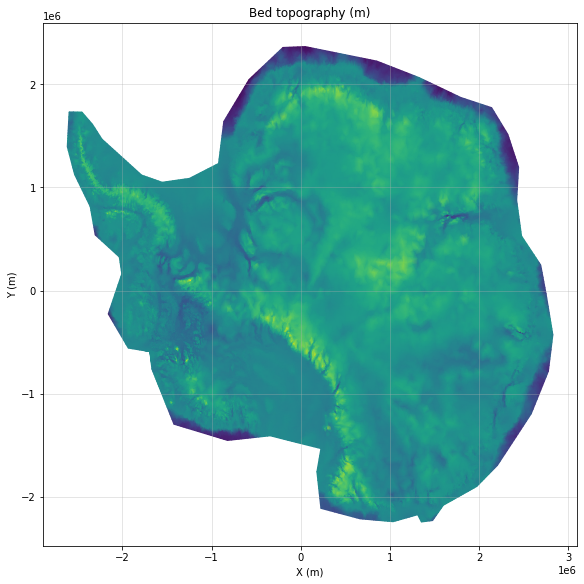

In [3]:
# Default 2D field plot
fig, ax = pyissm.plot.plot_model_field(md,
                                       md.geometry.bed,
                                       figsize = (8, 8))

# Add additional information to the plot
ax.grid(alpha = 0.4)
ax.set_title('Bed topography (m)')

plt.show()

As before, we can add additional complexity to these 2D field plots. Below, let's add some more complexity:

- **Panel 1**: We add the model mesh using the `show_mesh = True` option, and pass arguments to adjust the mesh appearance by providing a dictionary to `mesh_kwargs`. We can pass nested dictionaries to add and control the appearance of the nodes.

- **Panel 2**: We adjust the visualisation of the data to plot it on 'elements', rather than 'points' (which is the default). This displays the average value of the three points associated with each triangle.

- **Panel 3**: We add a colorbar to show the data values, and pass arguments to add a colorbar label by providing a dictionary to `cbar_kwargs`.

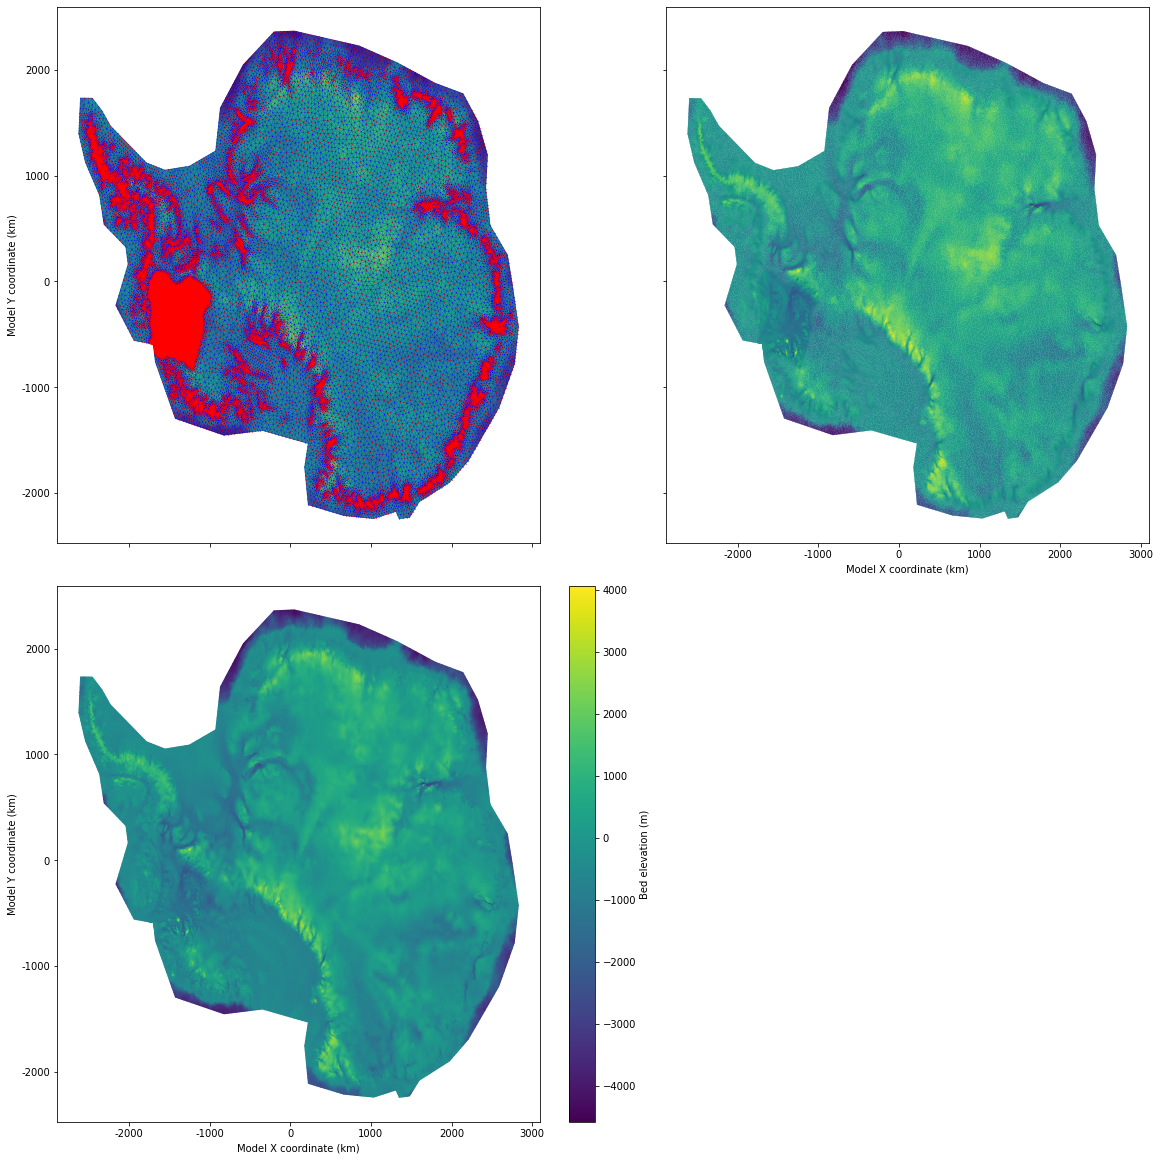

In [4]:
# Generate a 4-panel figure, with shared X/Y axes, constrained layout, and custom figure size
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (16, 16), sharey = True, sharex = True, constrained_layout = True)

# Add mesh, with optional arguments
ax1 = pyissm.plot.plot_model_field(md,
                                   md.geometry.bed,
                                   ax = ax1,
                                   ylabel = 'Model Y coordinate (km)',
                                   xlabel = '',
                                   show_mesh = True,
                                   mesh_kwargs = {'color': 'blue',
                                                'linewidth': 0.2,
                                                'show_nodes': True,
                                                'node_kwargs': {'color': 'red',
                                                              's': 0.2}})

# Plot data on elements
ax2 = pyissm.plot.plot_model_field(md,
                                   md.geometry.bed,
                                   ax = ax2,
                                   ylabel = '',
                                   xlabel = 'Model X coordinate (km)',
                                   plot_data_on = 'elements')

# Add colorbar to show data values, with optional arguments
ax3 = pyissm.plot.plot_model_field(md,
                                   md.geometry.bed,
                                   ax = ax3,
                                   ylabel = 'Model Y coordinate (km)',
                                   xlabel = 'Model X coordinate (km)',
                                   show_cbar = True,
                                   cbar_kwargs = {'label': 'Bed elevation (m)'})

# Turn off panel 4 and add x-labels back to ax2
ax4.axis('off')
ax2.tick_params(labelbottom=True)

# Adjust the X/Y ticks (only need to adjust ax1 as all subplots share X/Y axes)
formatter = matplotlib.ticker.FuncFormatter(lambda x, _: f"{x/1000:.0f}")  # Convert m to km
ax1.xaxis.set_major_formatter(formatter)
ax1.yaxis.set_major_formatter(formatter)

# 2. Visualise model results

## 2.1 - 2D fields

We can use a similar appraoch to visualise the change in a field over time. Below, let's look at thickness changes after 305 years. Below, we introduce some additional uses of `pyissm.plt.plot_model_field()`:

- We can limit the extent of data displayed by passing the `vmin` and `vmax` kwargs. Associated with this, we can extend the colorbar by including the `extend` option to the `cbar_kwargs` dictionary.

- We can modify the colormap of the difference plot by passing the `cmap` kwarg.

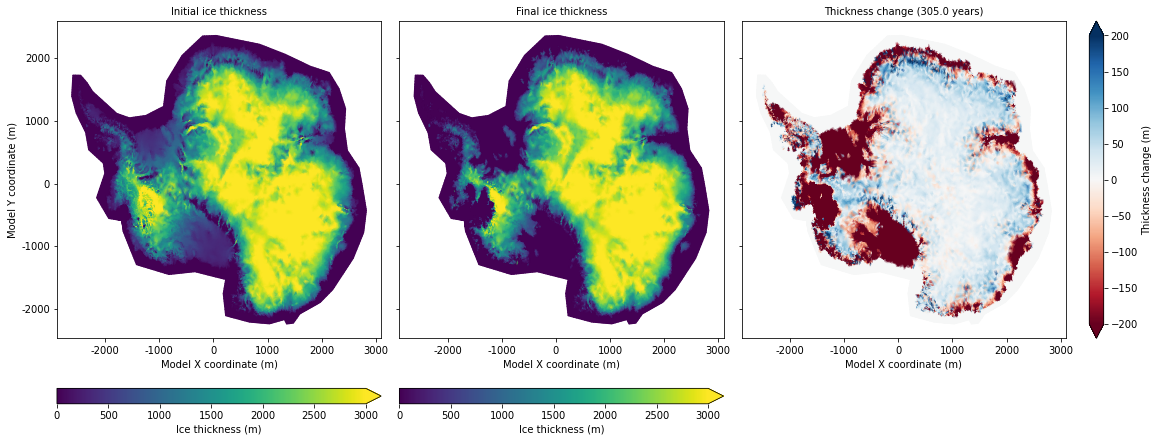

In [5]:
# Caculate the change in ice thickness over the simulation period
thickness_change = md.results.TransientSolution.Thickness[-1] - md.geometry.thickness

# Initialise a figure with 3 panels to visualise the change in ice thickness
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex = True, sharey = True, figsize=(16, 6), constrained_layout=True)

# Plot initial ice thickness
ax1 = pyissm.plot.plot_model_field(md,
                                   md.geometry.thickness,
                                   ax = ax1,
                                   vmin = 0,
                                   vmax = 3000,
                                   ylabel = 'Model Y coordinate (m)',
                                   xlabel = 'Model X coordinate (m)',
                                   show_cbar = True,
                                   cbar_kwargs = {'label': 'Ice thickness (m)',
                                                'orientation': 'horizontal',
                                                'extend': 'max'})

# Plot final ice thickness
ax2 = pyissm.plot.plot_model_field(md,
                                   md.results.TransientSolution.Thickness[-1],
                                   ax = ax2,
                                   vmin = 0,
                                   vmax = 3000,
                                   ylabel = '',
                                   xlabel = 'Model X coordinate (m)',
                                   show_cbar = True,
                                   cbar_kwargs = {'label': 'Ice thickness (m)',
                                                'orientation': 'horizontal',
                                                'extend': 'max'})

# Plot change in ice thickness
ax3 = pyissm.plot.plot_model_field(md,
                                   thickness_change,
                                   ax = ax3,
                                   cmap = 'RdBu',
                                   vmin = -200,
                                   vmax = 200,
                                   ylabel = '',
                                   xlabel = 'Model X coordinate (m)',
                                   show_cbar = True,
                                   cbar_kwargs = {'label': 'Thickness change (m)',
                                                'extend': 'both'})

# Adjust the X/Y ticks (only need to adjust ax1 as all subplots share X/Y axes)
formatter = matplotlib.ticker.FuncFormatter(lambda x, _: f"{x/1000:.0f}")  # Convert m to km
ax1.xaxis.set_major_formatter(formatter)
ax1.yaxis.set_major_formatter(formatter)

# Add titles to each subplot
ax1.set_title('Initial ice thickness', fontsize = 10)
ax2.set_title('Final ice thickness', fontsize = 10)
ax3.set_title(f'Thickness change ({md.results.TransientSolution.time[-1]} years)', fontsize = 10)

plt.show()

# 2.2 - 1D timeseries

In addition to 2D model fields, `pyISSM` also provides efficient tools for plotting timeseries output provided by ISSM. Here, we introduce the `pyissm.plot.plot_model_ts()` function.

In its simplest form, `pyissm.plot.plot_model_ts()` generates a figure with individual subplots for all 1D timeseries included in `md.results.TransientSolution`. We demonstrate this below.

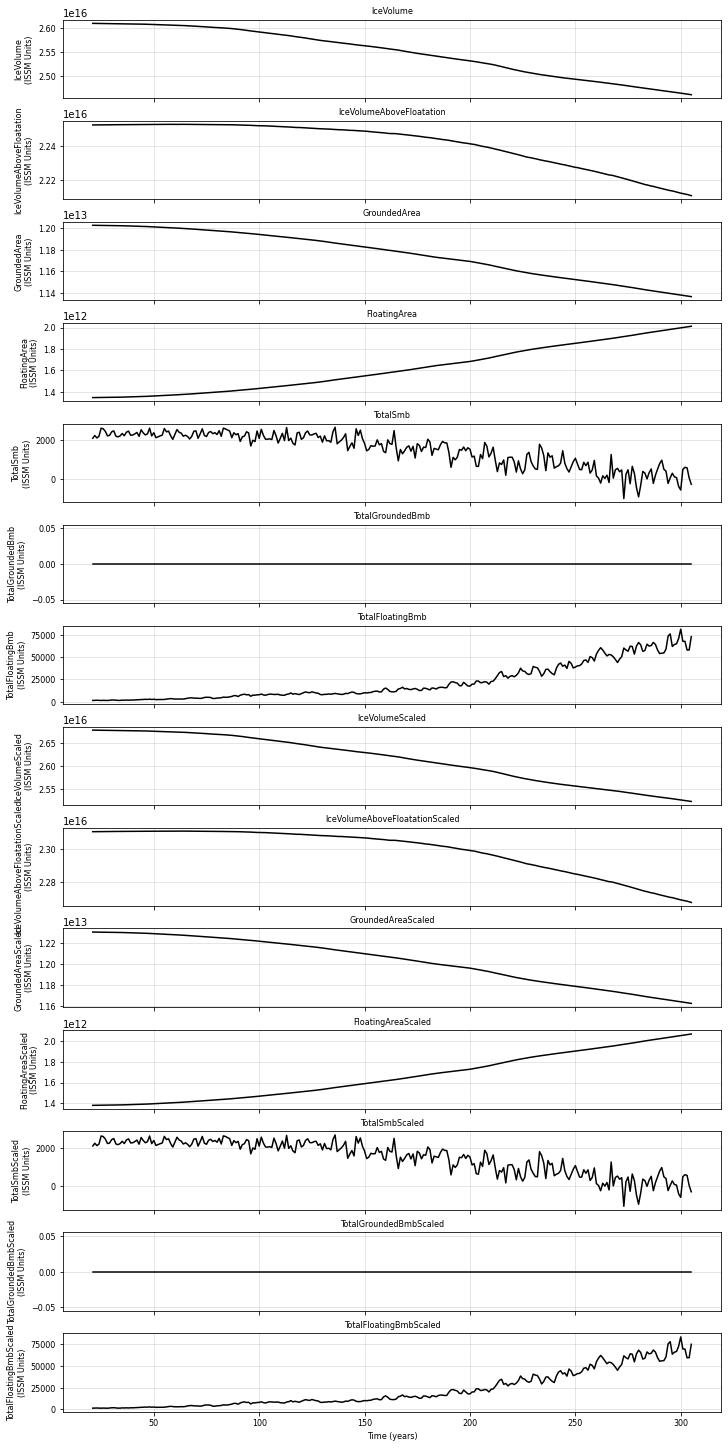

In [6]:
# Default 1D timeseries plot
# This will generate a figure with individual subplots for all 1D timeseries included in `md.results.TransientSolution`

fig, ax = pyissm.plot.plot_model_ts(md,
                                    figsize = (10, 20))

Users can plot a subset of model results by providing a `data_list` (and associated optional `variable_list` and `unit_list`). This appraoch allows users to specify data series with non-standard ISSM units. We demonstrate this below.

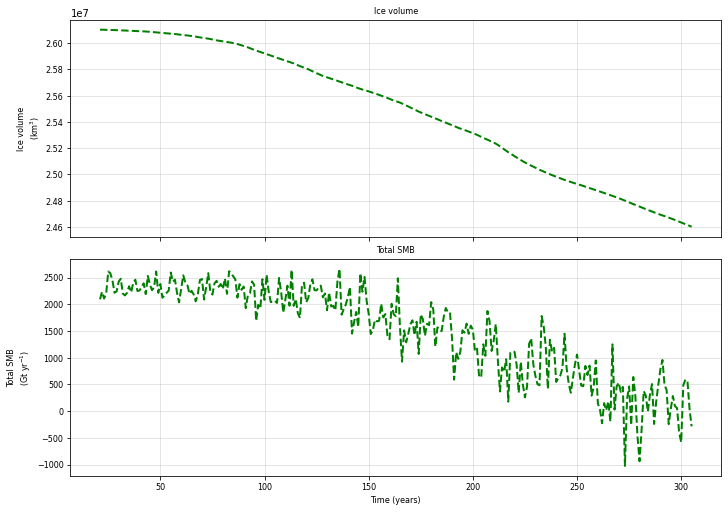

In [7]:
# Users can plot a subset of model results by providing a `data_list` (and associated optional `variable_list` and `unit_list`).
# This appraoch allows users to specify data series with non-standard ISSM units.

# Convert Ice Volume from m^3 to km^3
select_data = [md.results.TransientSolution.IceVolume / 1e9, md.results.TransientSolution.TotalSmb]

# Pass associated variable and unit names
variable_names = ['Ice volume', 'Total SMB']
unit_names = ['km$^3$', 'Gt yr$^{-1}$']

# Make customised plot
fig, ax = pyissm.plot.plot_model_ts(md,
                                    data_list = select_data,
                                    variable_list = variable_names,
                                    unit_list = unit_names,
                                    figsize = (10, 7),
                                    color = 'green',
                                    linewidth = 2,
                                    linestyle = '--')